In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt 
from vllm import LLM, SamplingParams


/home/yilong/miniconda3/envs/vllm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO 03-14 14:20:43 __init__.py:190] Automatically detected platform cuda.


2025-03-14 14:20:43,301	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [15]:
#llm = LLM(model="outputs/Qwen-0.5B-GRPO-Tom/checkpoint-563")
#llm = LLM(model="outputs/Qwen-0.5B-GRPO-Tom-512/checkpoint-773")
#llm = LLM(model="outputs/Qwen-0.5B-GRPO-Tom-512/checkpoint-300")
#llm = LLM(model="outputs/Qwen-0.5B-GRPO-Tom-WS/checkpoint-1268")
#llm = LLM(model="outputs/Qwen-0.5B-GRPO-Tom-WS/checkpoint-700")
#llm = LLM(model="outputs/Qwen-0.5B-GRPO-Tom-FT-WS/checkpoint-400")
llm =  LLM(model="outputs/Qwen-0.5B-GRPO-HI-New/checkpoint-500")
#llm = LLM(model="outputs/Qwen-0.5B-GRPO-TomC-FT-WS/checkpoint-200")


INFO 03-14 14:01:22 config.py:542] This model supports multiple tasks: {'generate', 'classify', 'reward', 'score', 'embed'}. Defaulting to 'generate'.
INFO 03-14 14:01:22 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.2) with config: model='outputs/Qwen-0.5B-GRPO-HI-New/checkpoint-500', speculative_config=None, tokenizer='outputs/Qwen-0.5B-GRPO-HI-New/checkpoint-500', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=32768, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=output

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  2.24it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  2.24it/s]


INFO 03-14 14:01:24 model_runner.py:1115] Loading model weights took 0.9277 GB


INFO 03-14 14:01:25 worker.py:267] Memory profiling takes 0.48 seconds
INFO 03-14 14:01:25 worker.py:267] the current vLLM instance can use total_gpu_memory (23.99GiB) x gpu_memory_utilization (0.90) = 21.59GiB
INFO 03-14 14:01:25 worker.py:267] model weights take 0.93GiB; non_torch_memory takes 0.08GiB; PyTorch activation peak memory takes 1.44GiB; the rest of the memory reserved for KV Cache is 19.14GiB.
INFO 03-14 14:01:25 executor_base.py:110] # CUDA blocks: 104553, # CPU blocks: 21845
INFO 03-14 14:01:25 executor_base.py:115] Maximum concurrency for 32768 tokens per request: 51.05x
INFO 03-14 14:01:25 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utilization` or switching to eager mode. You can also reduce the `max_num_seqs

Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:09<00:00,  3.74it/s]

INFO 03-14 14:01:35 model_runner.py:1562] Graph capturing finished in 9 secs, took -0.14 GiB
INFO 03-14 14:01:35 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 10.48 seconds


In [16]:
sampling_params = SamplingParams(temperature=0.6, max_tokens=512, top_p = 0.95)

# read data

In [2]:
from datasets import load_dataset, Dataset
import re
from tqdm import tqdm
import json

In [3]:
def extract_xml_answer(text: str) -> str:
    answer_pattern = r'<answer>(.*?)</answer>'
    matches = list(re.finditer(answer_pattern, text, re.DOTALL))
    if not matches:
        return None
        
    final_answer = matches[-1].group(1).strip()
    return final_answer



def normalize_answer(answer: str) -> str:
    """Normalizes the answer text for better comparison.
    Args:
        answer: Raw answer text
    Returns:
        Normalized answer text
    """
    if answer is None:
        return None
    # Convert to lowercase
    normalized = answer.lower()
    # Remove extra whitespace
    normalized = re.sub(r'\s+', ' ', normalized).strip()
    # Remove punctuation that doesn't affect meaning
    normalized = re.sub(r'[.,;:!?]', '', normalized)
    return normalized


In [4]:
def reward_func_(response, answer):
    response_ = extract_xml_answer(response)
    norm_response = normalize_answer(response_)
    norm_answer = normalize_answer(answer)
    if norm_response:
        if norm_response == norm_answer:
            return 1
        elif "in the " in norm_response:
            if norm_response.split('in the ')[-1] == norm_answer:
                return 1
        elif "\"" in norm_response:
            if norm_response.split("\"")[-1].split("\"")[0]== norm_answer:
                return 1
    
    return 0


def reward_func(response, answer):
    response_ = extract_xml_answer(response)
    if response_:
        norm_response = normalize_answer(response_)
        norm_answer = normalize_answer(answer)
        #ans_pattern = r"\b(?:in|at|on|inside)?\s*(?:the\s*)?" + re.escape(norm_answer) + r"\b$"
        ans_pattern = r".*?" + re.escape(norm_answer) + r"\s*$"
        match = re.match(ans_pattern, norm_response, re.DOTALL | re.MULTILINE)
        if match:
            return 1
        else:
            return 0
    return 0

In [5]:
testset = load_dataset('parquet', data_files='data/test/ToM_test.parquet')['train']
trainset = load_dataset('parquet', data_files='data/train/ToM_train.parquet')['train']

In [6]:
trainset

Dataset({
    features: ['deception', 'story_length', 'question_order', 'sample_id', 'story', 'question', 'choices', 'answer', 'question_old', 'answer_old', 'data_source', 'prompt', 'ability', 'reward_model', 'extra_info'],
    num_rows: 2000
})

In [7]:
testset

Dataset({
    features: ['deception', 'story_length', 'question_order', 'sample_id', 'story', 'question', 'choices', 'answer', 'question_old', 'answer_old', 'data_source', 'prompt', 'ability', 'reward_model', 'extra_info', 'story_structure', 'infilled_story', 'question_type', 'params', 'nth_order', 'is_interesting', 'story_type', 'story_structure_wn'],
    num_rows: 1600
})

In [8]:
testset['prompt'][0]

[{'content': 'You are a helpful assistant. The assistant first thinks about the reasoning process in the mind and then provides the user with the answer. The reasoning process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., <think> reasoning process here </think><answer> answer here </answer>.',
  'role': 'system'},
 {'content': 'Story: Benjamin, Emily, Mason, Evelyn and Jackson entered the living_room. The persimmon is in the green_basket. Benjamin moved the persimmon to the green_suitcase. Benjamin exited the living_room. Benjamin saw a dog. Emily moved the persimmon to the blue_bathtub. Emily exited the living_room. Mason made no movements and stayed in the living_room for 1 minute. Mason exited the living_room. Evelyn moved the persimmon to the red_crate. Evelyn exited the living_room. Jackson made no movements and stayed in the living_room for 1 minute. Jackson exited the living_room. Benjamin, Emily, Mason, Evelyn and Jackson enter

In [9]:
def get_res(llm, testset, sampling_params):
    model_results = llm.chat(testset['prompt'], sampling_params, use_tqdm=True)
    results = {'output':[], 'answer':[], 'response':[], 'correctness':[]}
    for each, answer in zip(model_results, testset['answer']):
        results['output'].append(each.outputs[0].text)
        results['answer'].append(answer)
        results['response'].append(normalize_answer(extract_xml_answer(each.outputs[0].text)))
        results['correctness'].append(reward_func(each.outputs[0].text, answer) )

    df = pd.DataFrame(results)
    return df

In [25]:
dftrain = get_res(llm, trainset, sampling_params)

INFO 03-14 14:02:00 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.


Processed prompts: 100%|██████████| 2000/2000 [01:19<00:00, 25.20it/s, est. speed input: 8836.51 toks/s, output: 731.04 toks/s] 


In [29]:
dftrain.to_csv('data/results/test_results/HI_train.csv', index=False)

In [10]:
dftrain = pd.read_csv('data/results/test_results/HI_train.csv')
dftrain.head(2)

,output,answer,response,correctness,question_order,deception,story,choices
0,<think> Lily made no movements and stayed in t...,green_cupboard,the green_cupboard,1,3,True,"Lily, Hannah, Emma, Jackson and Gracie entered...","A. green_drawer, B. red_container, C. blue_box..."
1,<think> Mila made no movements and stayed in t...,red_crate,the red_crate,1,3,False,"Mila, Benjamin, Emily, Noah and Isabella enter...","A. red_crate, B. red_bottle, C. blue_drawer, D..."


In [109]:
dftrain['question_order']=trainset['question_order']
dftrain['deception']=trainset['deception']
dftrain['story']=trainset['story']
dftrain['choices']=trainset['choices']
dftrain['question']=trainset['question']


In [123]:
s = []
for i, each in enumerate(dftrain['question'].apply(lambda x:x.split()[2])):
    if each in dftrain['story'][i].split('entered')[0]:
        a = dftrain['story'][i].split('entered')[0]
        a = a.replace(',', '').replace(' and ', ' ').split()
        s.append(a.index(each))
    else:
        s.append(-1)

In [125]:
dftrain['ind']=s

<Axes: xlabel='ind', ylabel='count'>

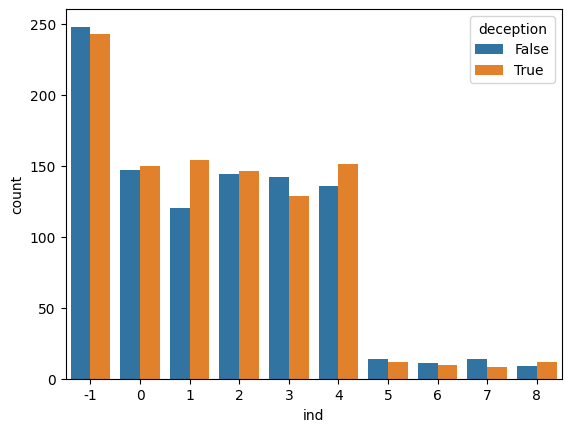

In [128]:
sns.countplot(x='ind', data=dftrain, hue='deception')

In [13]:
np.unique(dftrain.choices.apply(lambda x: len(x.split(','))))

array([15])

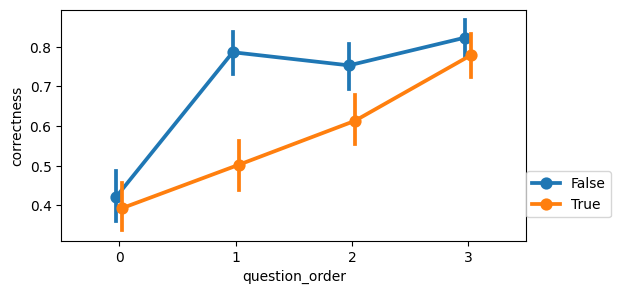

In [13]:
_, ax = plt.subplots(1,1,figsize=(6, 3))
sns.pointplot(x='question_order', y='correctness', hue='deception', data=dftrain, dodge=True)
ax.legend(loc=(1, 0.1))

In [17]:
dftrain.loc[dftrain.question_order==0]

,output,answer,response,correctness,question_order,deception,story
5,<think> Alexander made no movements and stayed...,red_drawer,the red_bottle,0,0,True,"Alexander, Chloe, Jack, Ella and Jackson enter..."
11,<think> Jayden made no movements and stayed in...,green_suitcase,the red_bucket,0,0,True,"Jayden, Nathan, Amelia, Charlotte and Gracie e..."
16,<think> Avery moved the beans to the blue_buck...,green_drawer,the green_drawer,1,0,False,"Avery, Amelia, Nathan, Alexander and Gracie en..."
25,<think> Jackson moved the lettuce to the red_c...,red_envelope,the red_crate,0,0,True,"Jackson lost his gloves. Jackson, William, Ari..."
36,<think> Avery made no movements and stayed in ...,blue_basket,the blue_basket,1,0,True,"Avery, Lily, Amelia, Isla and Oliver entered t..."
...,...,...,...,...,...,...,...
1979,<think> Isabella dislikes the apple. The apple...,green_bathtub,the green_basket,0,0,False,"Isabella, Ella, Emma, Oliver and Alexander ent..."
1980,<think> Chloe moved the spinach to the green_c...,blue_basket,the blue_suitcase,0,0,True,"Chloe, Alexander, Noah, Hannah and Oliver ente..."
1982,<think> Ava moved the broccoli to the green_cu...,red_bucket,the red_bucket,1,0,True,"Ava, Charlotte, Gracie, Isabella and Elizabeth..."
1985,<think> Elizabeth moved the pear to the green_...,red_crate,the green_crate,0,0,False,"Elizabeth, Benjamin, Noah, Gracie and Jackson ..."


In [28]:
df = get_res(llm, testset, sampling_params)

Processed prompts: 100%|██████████| 1600/1600 [00:39<00:00, 40.02it/s, est. speed input: 12391.25 toks/s, output: 1191.01 toks/s] 


In [30]:
df.to_csv('data/results/test_results/HI_test.csv', index=False)

In [14]:
df = pd.read_csv('data/results/test_results/HI_test.csv')
df.head(2)

,output,answer,response,correctness
0,<think> Benjamin moved the persimmon to the gr...,green_suitcase,the green_suitcase,1
1,<think> Mason moved the asparagus to the red_d...,red_drawer,the red_drawer,1


In [15]:
#dfrt = pd.DataFrame(test_results)
dfrt=df.copy()
dfrt['question_order']=testset['question_order']
dfrt['nth_order']=testset['nth_order']
dfrt['data_source']=testset['data_source']
dfrt = dfrt.fillna(0)
dfrt['Order']=dfrt.nth_order+dfrt.question_order
dfrt.head()

,output,answer,response,correctness,question_order,nth_order,data_source,Order
0,<think> Benjamin moved the persimmon to the gr...,green_suitcase,the green_suitcase,1,4.0,0.0,hi_tom,4.0
1,<think> Mason moved the asparagus to the red_d...,red_drawer,the red_drawer,1,4.0,0.0,hi_tom,4.0
2,<think> Noah moved the onion to the blue_drawe...,red_drawer,the blue_drawer,0,4.0,0.0,hi_tom,4.0
3,<think> Noah moved the tangerine to the green_...,green_pantry,the green_pantry,1,4.0,0.0,hi_tom,4.0
4,<think> Olivia moved the tangerine to the red_...,red_crate,the red_crate,1,4.0,0.0,hi_tom,4.0


In [16]:
dfrt['ext_answer'] = dfrt.response.apply(lambda x:x.split()[-1])

In [17]:
dfrt.loc[dfrt.data_source=='explore_tom']

,output,answer,response,correctness,question_order,nth_order,data_source,Order,ext_answer
1000,<think> William entered the back office of the...,cardboard box,cardboard box,1,0.0,2.0,explore_tom,2.0,box
1001,<think> Lauren entered the visitor center. </t...,leather pouch,the leather pouch,1,0.0,1.0,explore_tom,1.0,pouch
1002,<think> Jasmine moved the silver letter opener...,consulate reception area,consulate reception area,1,0.0,-1.0,explore_tom,-1.0,area
1003,<think> Abigail told privately to Jasmine that...,waiting lounge,waiting lounge,1,0.0,-1.0,explore_tom,-1.0,lounge
1004,<think> Justin moved the pocket-sized notebook...,canvas tote bag,the cardboard file box,0,0.0,1.0,explore_tom,1.0,box
...,...,...,...,...,...,...,...,...,...
1595,<think> Tyler moved the small bag of dog treat...,cardboard box,the canvas tote bag,0,0.0,1.0,explore_tom,1.0,bag
1596,<think> Jessica moved the tactical flashlight ...,operations room,the metal toolbox,0,0.0,2.0,explore_tom,2.0,toolbox
1597,"<think> Lachlan moved the small, leather-bound...",wooden desk drawer,wooden desk drawer,1,0.0,-1.0,explore_tom,-1.0,drawer
1598,"<think> Brody moved the small, antique pocket ...",wooden box,the metal safe,0,0.0,1.0,explore_tom,1.0,safe


In [18]:
dft = dfrt.loc[dfrt.data_source=='explore_tom'].copy()
dft.index = range(len(dft))
dft['is_interesting'] = testset['is_interesting'][1000:]
dft['story_type'] = testset['story_type'][1000:]
dft['question_type'] = testset['question_type'][1000:]
dft['question'] = testset['question'][1000:]
dft['story_structure'] = testset['story_structure'][1000:]

In [19]:
testset

Dataset({
    features: ['deception', 'story_length', 'question_order', 'sample_id', 'story', 'question', 'choices', 'answer', 'question_old', 'answer_old', 'data_source', 'prompt', 'ability', 'reward_model', 'extra_info', 'story_structure', 'infilled_story', 'question_type', 'params', 'nth_order', 'is_interesting', 'story_type', 'story_structure_wn'],
    num_rows: 1600
})

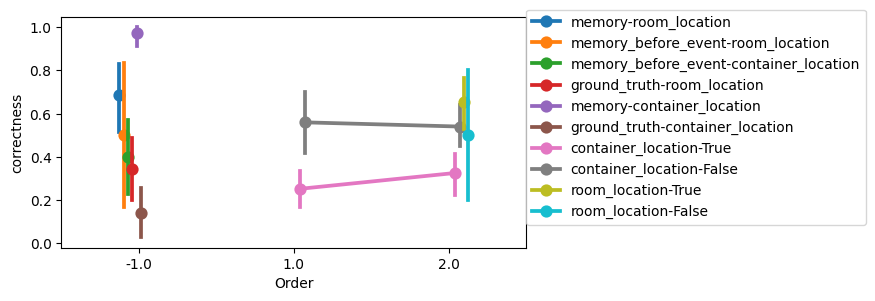

In [105]:
_, ax = plt.subplots(1,1,figsize=(6, 3))
sns.pointplot(x='Order', y='correctness', hue='question_type', data=dft, dodge=True)
ax.legend(loc=(1, 0.1))

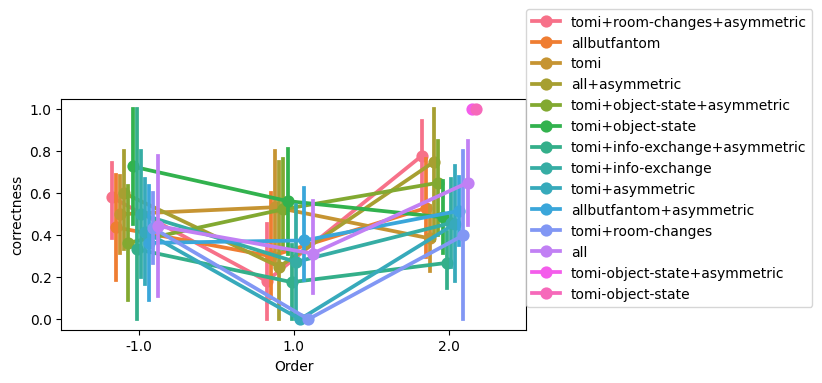

In [20]:
_, ax = plt.subplots(1,1,figsize=(6, 3))
sns.pointplot(x='Order', y='correctness', hue='story_type', data=dft, dodge=True)
ax.legend(loc=(1, 0.1))

In [106]:
np.unique(dft.question_type)

array(['container_location-False', 'container_location-True',
       'ground_truth-container_location', 'ground_truth-room_location',
       'memory-container_location', 'memory-room_location',
       'memory_before_event-container_location',
       'memory_before_event-room_location', 'room_location-False',
       'room_location-True'], dtype=object)

In [109]:
dft.loc[dft.question_type=='ground_truth-container_location']['output'][593]

'<think> William moved the pocket-sized calculator to the lunchbox, which is also located in the collaborative study room. </think> <answer> the lunchbox </answer>'

In [115]:
dft.loc[dft.question_type=='ground_truth-container_location']['story_structure'][593]

'William entered the collaborative study room. William set the date of the pocket-sized calculator to a birthday or another meaningful date. William moved the pocket-sized calculator to the cardboard box, which is also located in the collaborative study room. William moved the pocket-sized calculator to the lunchbox, which is also located in the collaborative study room. While this action was happening, Landon witnessed this action in secret (and only this action). William left the collaborative study room. William entered the collaborative study room. Landon entered the collaborative study room. William moved the pocket-sized calculator to the backpack, which is also located in the collaborative study room.'

In [17]:
len(testset['data_source'])

1600

In [18]:
len(dfrt)

1600

<Axes: xlabel='Order', ylabel='count'>

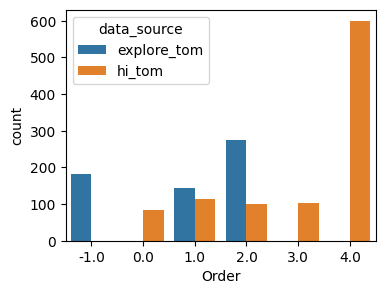

In [19]:
_, ax = plt.subplots(1,1,figsize=(4, 3))
sns.countplot(x='Order', hue='data_source', data=dfrt)

<Axes: xlabel='Order', ylabel='correctness'>

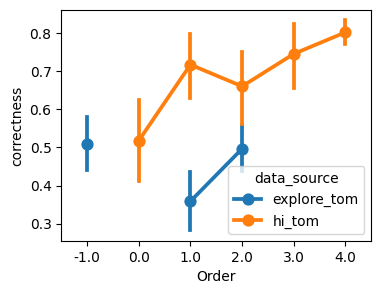

In [80]:
_, ax = plt.subplots(1,1,figsize=(4, 3))
sns.pointplot(x='Order', y='correctness', hue='data_source', data=dfrt)

In [116]:
dfrt.loc[dfrt.Order==0]

,output,answer,response,correctness,question_order,nth_order,data_source,Order,ext_answer
600,<think> Amelia moved the lettuce to the blue_b...,red_suitcase,the red_suitcase,1,0.0,0.0,hi_tom,0.0,red_suitcase
602,<think> Lily saw a monkey. The spinach is in t...,green_bottle,the red_treasure_chest,0,0.0,0.0,hi_tom,0.0,red_treasure_chest
603,"<think> Oliver saw a cat. Gracie, Hannah, Jayd...",blue_container,the red_suitcase,0,0.0,0.0,hi_tom,0.0,red_suitcase
608,<think> Mason moved the celery to the blue_sui...,red_bottle,the blue_treasure_chest,0,0.0,0.0,hi_tom,0.0,blue_treasure_chest
609,<think> Ella made no movements and stayed in t...,green_box,the green_basket,0,0.0,0.0,hi_tom,0.0,green_basket
...,...,...,...,...,...,...,...,...,...
979,<think> Charlotte moved the peach to the red_b...,green_cupboard,the green_cupboard,1,0.0,0.0,hi_tom,0.0,green_cupboard
980,<think> Isla dislikes the pineapple. </think> ...,green_bottle,the blue_container,0,0.0,0.0,hi_tom,0.0,blue_container
988,<think> Ethan moved the cabbage to the green_d...,blue_pantry,the blue_pantry,1,0.0,0.0,hi_tom,0.0,blue_pantry
991,<think> Nathan moved the orange to the blue_su...,red_drawer,the green_bottle,0,0.0,0.0,hi_tom,0.0,green_bottle


In [1]:
'blue_container'.replace('_', ' ')

'blue container'

<Axes: xlabel='Order', ylabel='correctness'>

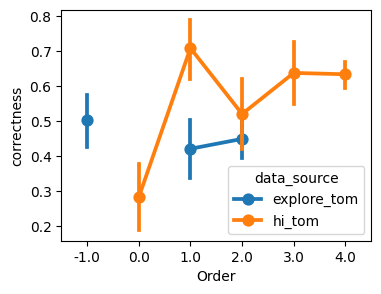

In [24]:
_, ax = plt.subplots(1,1,figsize=(4, 3))
sns.pointplot(x='Order', y='correctness', hue='data_source', data=dfrt)

<Axes: xlabel='data_source', ylabel='correctness'>

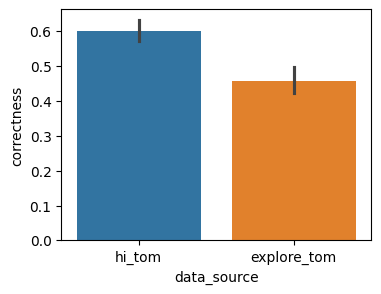

In [25]:
_, ax = plt.subplots(1,1,figsize=(4, 3))
sns.barplot(x='data_source', y='correctness', hue='data_source', data=dfrt)

In [21]:
dfrt.groupby('data_source').correctness.mean()

data_source
explore_tom    0.470
hi_tom         0.739
Name: correctness, dtype: float64

In [24]:
dfrt.groupby('data_source').correctness.mean()

data_source
explore_tom    0.476667
hi_tom         0.741000
Name: correctness, dtype: float64

In [26]:
dfrt.groupby('data_source').correctness.mean()

data_source
explore_tom    0.458333
hi_tom         0.601000
Name: correctness, dtype: float64

In [27]:
dfrt.loc[(dfrt.Order==0)&(dfrt.correctness==0)].iloc[0].output

'<think> Amelia moved the lettuce to the blue_bathtub. </think> \n<answer> The blue_bathtub </answer>'

# Other Set

In [22]:
test_faux = load_dataset('parquet', data_files='data/test/test_faux.parquet')['train']
test_hitom = load_dataset('parquet', data_files='data/test/test_hitom.parquet')['train']
test_tomi = load_dataset('parquet', data_files='data/test/test_tomi.parquet')['train']

test_hitom_num = load_dataset('parquet', data_files='data/test/test_hitom_num.parquet')['train']
test_tomi_num = load_dataset('parquet', data_files='data/test/test_tomi_num.parquet')['train']

In [27]:
test_hitom

Dataset({
    features: ['deception', 'story_length', 'question_order', 'sample_id', 'story', 'question', 'choices', 'answer', 'question_old', 'answer_old', 'prompt'],
    num_rows: 600
})

In [28]:
test_hitom['prompt'][0]

[{'content': 'You are a helpful assistant. The assistant first thinks about the reasoning process in the mind and then provides the user with the answer. The reasoning process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., <think> reasoning process here </think><answer> answer here </answer>.',
  'role': 'system'},
 {'content': 'Story: Charlotte, Isabella, Elizabeth and Owen entered the living_room. lettuce is in the green_drawer. moved the lettuce to the green_bathtub. dislikes the tangerine. exited the living_room. moved the lettuce to the blue_pantry. likes the green_envelope. exited the living_room. made no movements and stayed in the living_room for 1 minute. exited the living_room. dislikes the green_pepper. made no movements and stayed in the living_room for 1 minute. exited the living_room. moved the lettuce to the green_drawer. exited the living_room. Charlotte, Isabella, Elizabeth and Owen entered the waiting_room.\n Question:

In [33]:
results_hitom = get_res(llm, test_hitom, sampling_params)

Processed prompts: 100%|██████████| 600/600 [00:21<00:00, 28.28it/s, est. speed input: 8983.69 toks/s, output: 1074.56 toks/s]


In [64]:
results_hitom['ext_answer'] = results_hitom.response.apply(lambda x:x.split()[-1])

In [34]:
results_hitom.correctness.mean()

0.525

<Axes: xlabel='ext_answer', ylabel='answer'>

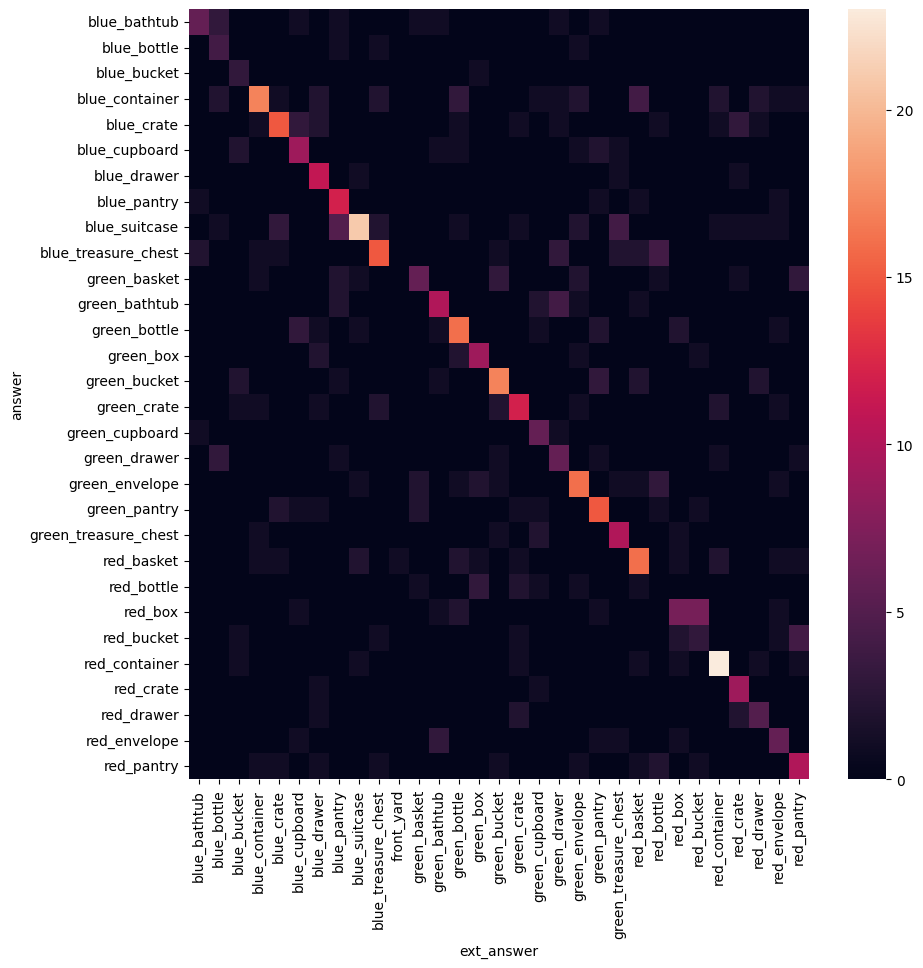

In [73]:
_, ax = plt.subplots(1,1, figsize=(10,10))
sns.heatmap(results_hitom.pivot_table(index='answer', columns='ext_answer', values='correctness', aggfunc='count', fill_value=0))

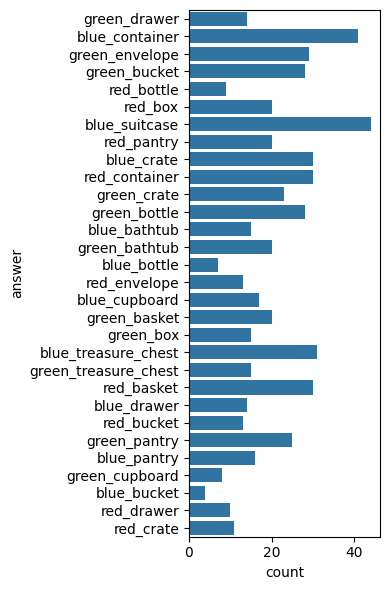

In [68]:
_, ax = plt.subplots(1,1, figsize=(4,6))
sns.countplot(y='answer', data=results_hitom)
plt.tight_layout()

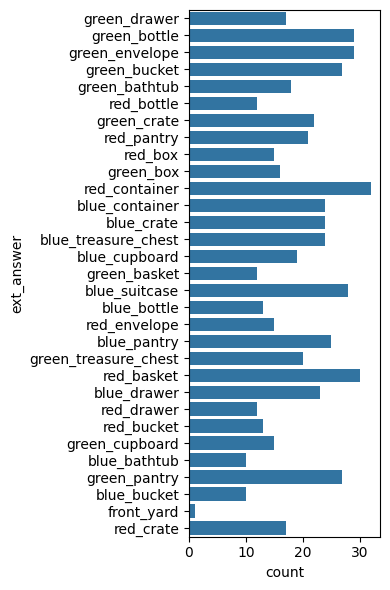

In [66]:
_, ax = plt.subplots(1,1, figsize=(4,6))
sns.countplot(y='ext_answer', data=results_hitom)
plt.tight_layout()

In [26]:
results_hitom_num = get_res(llm, test_hitom, sampling_params)
results_hitom_num.correctness.mean()

Processed prompts: 100%|██████████| 600/600 [00:29<00:00, 20.34it/s, est. speed input: 6460.56 toks/s, output: 773.68 toks/s] 


0.5133333333333333

<Axes: ylabel='correctness'>

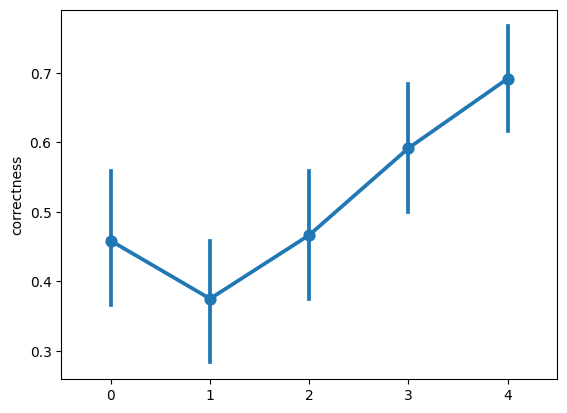

In [27]:
sns.pointplot(x = test_hitom['question_order'], y = results_hitom['correctness'])

In [39]:
test_tomi['prompt'][0]

[{'content': 'You are a helpful assistant. The assistant first thinks about the reasoning process in the mind and then provides the user with the answer. The reasoning process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., <think> reasoning process here </think><answer> answer here </answer>.',
  'role': 'system'},
 {'content': 'Story: Jackson entered the hall. Chloe entered the hall. The boots is in the bathtub. Jackson exited the hall. Jackson entered the dining_room. Chloe moved the boots to the pantry.\n Question:Where was the boots at the beginning?',
  'role': 'user'}]

In [51]:
results_tomi = get_res(llm, test_tomi, sampling_params)
results_tomi = results_tomi.fillna('None')
results_tomi.correctness.mean()

Processed prompts: 100%|██████████| 5994/5994 [01:51<00:00, 53.74it/s, est. speed input: 7790.17 toks/s, output: 1301.80 toks/s] 


0.38872205538872207

In [53]:
results_tomi['ext_answer'] = results_tomi.response.apply(lambda x:x.split()[-1])

In [60]:
np.unique(results_tomi['answer'])

array(['basket', 'bathtub', 'bottle', 'box', 'bucket', 'container',
       'crate', 'cupboard', 'drawer', 'envelope', 'pantry', 'suitcase',
       'treasure_chest'], dtype=object)

In [54]:
np.unique(results_tomi['ext_answer'])

array(['None', 'attic', 'back_yard', 'basement', 'basket', 'bathroom',
       'bathtub', 'beans', 'bedroom', 'bottle', 'bottles', 'box',
       'broccoli', 'bucket', 'cabbage', 'carrot', 'cellar', 'closet',
       'container', 'corn', 'crate', 'crates', 'crawlspace', 'cupboard',
       'den', 'dining_room', 'drawer', 'dress', 'envelope', 'front_yard',
       'garage', 'garden', 'green_pepper', 'hall', 'hallway', 'hat',
       'kitchen', 'laundry', 'lettuce', 'living_room', 'lounge',
       'master_bedroom', 'office', 'pantry', 'patio', 'patroniel', 'pear',
       'persimmon', 'playroom', 'porch', 'potato', 'pumpkin', 'room',
       'shoes', 'slacks', 'spinach', 'staircase', 'stocking', 'stockings',
       'study', 'suit', 'suitcase', 'sunroom', 'sweater', 'sweatshirt',
       'sweet_potato', 'treasure_chest', 'trousers', 'tv_room',
       'underclothes', 'underpants', 'watermelon', 'workshop'],
      dtype=object)

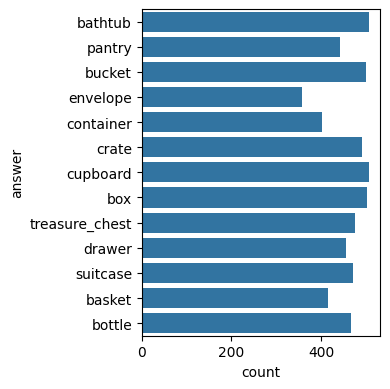

In [63]:
_, ax = plt.subplots(1,1, figsize=(4,4))
sns.countplot(y='answer', data=results_tomi)
plt.tight_layout()

<Axes: xlabel='answer', ylabel='ext_answer'>

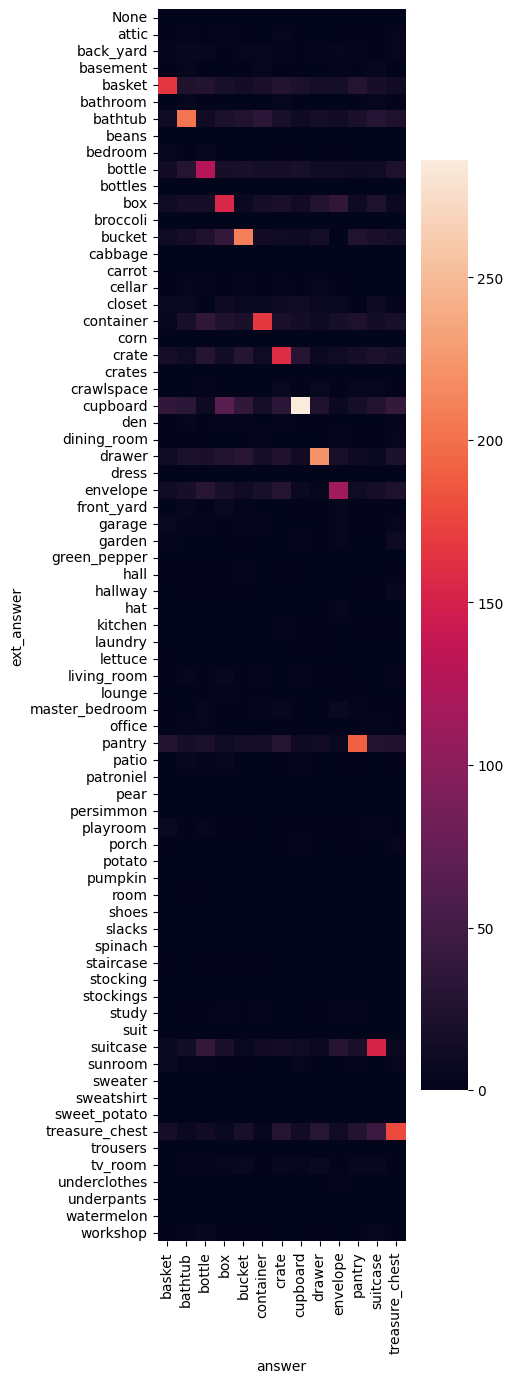

In [77]:
_, ax = plt.subplots(1,1, figsize=(4,16))
sns.heatmap(results_tomi.pivot_table(index='ext_answer', columns='answer', values='correctness', aggfunc='count', fill_value=0))

In [38]:
results_tomi['output'][0]

'<think> Jackson entered the hall. Chloe entered the hall. </think> <answer> the bathtub </answer>'

In [33]:
test_tomi

Dataset({
    features: ['story', 'question', 'answer', 'question_type', 'prompt'],
    num_rows: 5994
})

<Axes: ylabel='correctness'>

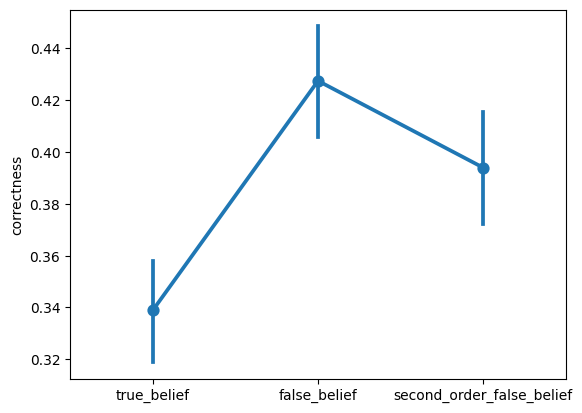

In [30]:
sns.pointplot(x = test_tomi['question_type'], y = results_tomi['correctness'])

In [60]:
results_faux = main_func(llm, test_faux, 5, n_repeat=3)

Processing batches: 100%|██████████| 36/36 [00:31<00:00,  1.15it/s, accuracy=0.29] 

Correct: 0.2897727272727273


In [61]:
model_name = 'Hi'
pd.DataFrame(results_hitom).to_csv('data/results/hitom_{}.csv'.format(model_name), index=False)
pd.DataFrame(results_tomi).to_csv('data/results/tomi_{}.csv'.format(model_name), index=False)
pd.DataFrame(results_faux).to_csv('data/results/faux_{}.csv'.format(model_name), index=False)

In [70]:
dfe  =pd.read_csv('data/reasoning_model_eval_2.csv')

In [71]:
dfe.head(2)

,story,question,answer,question_type,model_answer,final_answer,is_correct,question_type2
0,Jackson entered the hall. Chloe entered the ha...,Where was the boots at the beginning?,bathtub,true_belief,"1. Initially, the boots are in the bathtub.\n2...",bathtub,True,memory
1,Jackson entered the hall. Chloe entered the ha...,Where will Chloe look for the boots?,pantry,true_belief,"1. Initially, the boots were in the bathtub.\n...",pantry,True,first_order_1_no_tom


In [72]:
len(dfe)

5994

In [73]:
np.unique(dfe.final_answer.astype(str))

array(['TV_room', 'attic', 'back_yard', 'basement', 'basket', 'bathhtub',
       'bathroom', 'bathtub', 'bedroom', 'bottle', 'box', 'bucket',
       'cellar', 'closet', 'container', 'crate', 'crawlspace',
       'crawlspaces', 'cupboard', 'den', 'dining_room', 'drawer',
       'envelope', 'front_yard', 'garage', 'garden', 'hall', 'hallway',
       'in the bottle', 'kitchen', 'laundry', 'living_room', 'lounge',
       'master_bedroom', 'nan', 'office', 'on the bottle', 'pantry',
       'patio', 'playroom', 'porch', 'staircase', 'study', 'suitcase',
       'sunroom', 'the bottle', 'the_bottle', 'treasure_chest', 'tv_room',
       'workshop'], dtype=object)

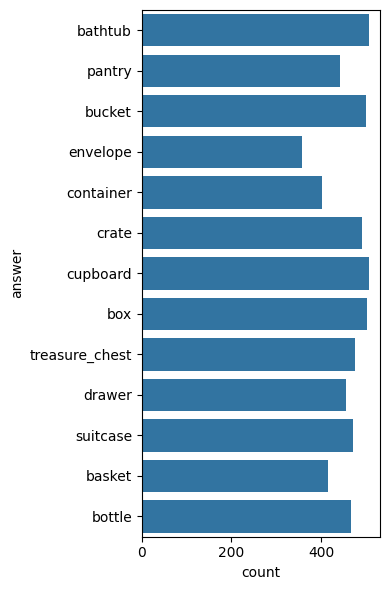

In [74]:
_, ax = plt.subplots(1,1, figsize=(4,6))
sns.countplot(y='answer', data=dfe)
plt.tight_layout()

In [75]:
room = []
for each in np.unique(dfe.final_answer.astype(str)):
    if 'room' in each:
        room.append(each)

In [76]:
has_room = []
for each in np.unique(dfe.final_answer.astype(str)):
    if 'room' in each:
        has_room.append(1)
    else:
        has_room.append(0)

In [77]:
dfe['ans_room']=dfe.final_answer.apply(lambda x: x in room)

In [78]:
dfe.fillna('None')

,story,question,answer,question_type,model_answer,final_answer,is_correct,question_type2,ans_room
0,Jackson entered the hall. Chloe entered the ha...,Where was the boots at the beginning?,bathtub,true_belief,"1. Initially, the boots are in the bathtub.\n2...",bathtub,True,memory,False
1,Jackson entered the hall. Chloe entered the ha...,Where will Chloe look for the boots?,pantry,true_belief,"1. Initially, the boots were in the bathtub.\n...",pantry,True,first_order_1_no_tom,False
2,Jackson entered the hall. Chloe entered the ha...,Where does Chloe think that Jackson searches f...,bathtub,true_belief,"1. Initially, the boots are in the bathtub.\n2...",None,False,second_order_1_tom,False
3,Jackson entered the hall. Chloe entered the ha...,Where is the boots really?,pantry,true_belief,"1. Initially, the boots were in the bathtub.\n...",pantry,True,reality,False
4,Jackson entered the hall. Chloe entered the ha...,Where will Jackson look for the boots?,bathtub,true_belief,"1. Initially, the boots are in the bathtub.\n2...",hall,False,first_order_0_tom,False
...,...,...,...,...,...,...,...,...,...
5989,Logan hates the jacket Logan entered the bedro...,Where will Logan look for the peas?,crate,second_order_false_belief,"1. Initially, the peas were in the envelope.\n...",crate,True,first_order_0_no_tom,False
5990,Logan hates the jacket Logan entered the bedro...,Where does Logan think that Aria searches for...,envelope,second_order_false_belief,"1. Initially, the peas are in the envelope.\n2...",envelope,True,second_order_0_tom,False
5991,Logan hates the jacket Logan entered the bedro...,Where is the peas really?,crate,second_order_false_belief,"1. Initially, the peas were in the envelope.\n...",crate,True,reality,False
5992,Logan hates the jacket Logan entered the bedro...,Where will Aria look for the peas?,crate,second_order_false_belief,"1. Initially, the peas were in the envelope.\n...",crate,True,first_order_1_no_tom,False


In [79]:
df1 = dfe.loc[dfe.final_answer.isin(np.unique(dfe.answer))]

In [80]:
len(df1)

5669

<Axes: xlabel='answer', ylabel='is_correct'>

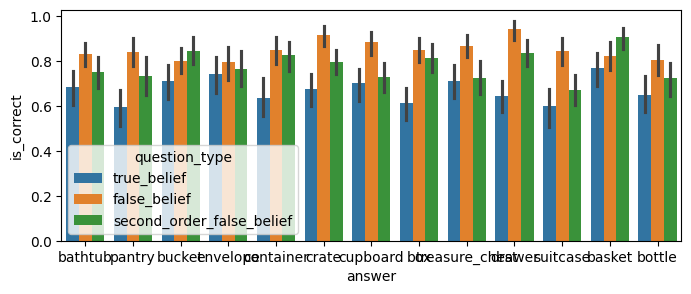

In [81]:
_, ax = plt.subplots(1,1, figsize=(8, 3))
sns.barplot(x='answer', y='is_correct', hue='question_type', data=df1)

In [83]:
len(df1)

5669

In [96]:
dfe['no_tom'] = dfe.question_type2.apply(lambda x: 'no_tom' in x)

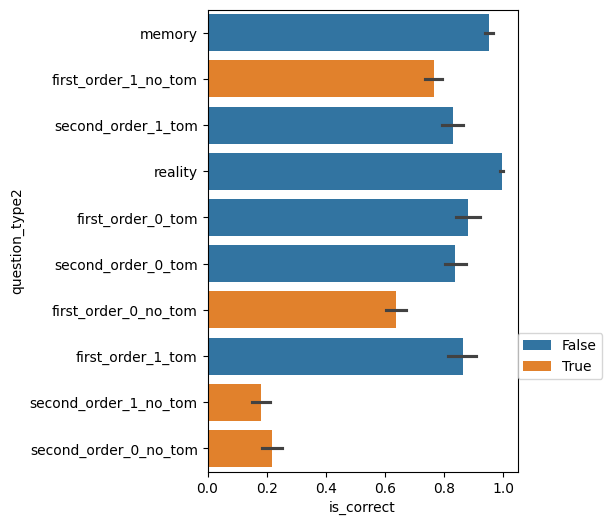

In [97]:
_, ax = plt.subplots(1,1, figsize=(4, 6))
sns.barplot(y='question_type2', x='is_correct', hue='no_tom', data=dfe)
ax.legend(loc=(1, 0.2))
#plt.tight_layout()

In [98]:
dfe.groupby('no_tom').is_correct.mean()

no_tom
False    0.924511
True     0.485672
Name: is_correct, dtype: float64

In [99]:
dfe.groupby('no_tom').is_correct.count()

no_tom
False    3272
True     2722
Name: is_correct, dtype: int64

In [101]:
dfe.loc[dfe.no_tom].story[1]

'Jackson entered the hall. Chloe entered the hall. The boots is in the bathtub. Jackson exited the hall. Jackson entered the dining_room. Chloe moved the boots to the pantry.'

In [102]:
dfe.loc[dfe.no_tom].question[1]

'Where will Chloe look for the boots?'

In [103]:
dfe.loc[dfe.no_tom]

,story,question,answer,question_type,model_answer,final_answer,is_correct,question_type2,ans_room,no_tom
1,Jackson entered the hall. Chloe entered the ha...,Where will Chloe look for the boots?,pantry,true_belief,"1. Initially, the boots were in the bathtub.\n...",pantry,True,first_order_1_no_tom,False,True
7,Hannah entered the patio. Noah entered the pat...,Where will Hannah look for the sweater?,pantry,false_belief,"1. Initially, the sweater was in the bucket.\n...",pantry,True,first_order_0_no_tom,False,True
13,Carter entered the cellar. Jacob entered the w...,Where will Mia look for the gloves?,container,true_belief,"1. Initially, the gloves were in the envelope....",container,True,first_order_1_no_tom,False,True
14,Carter entered the cellar. Jacob entered the w...,Where does Mia think that Carter searches for ...,container,true_belief,"1. Initially, the gloves are in the envelope.\...",envelope,False,second_order_1_no_tom,False,True
16,Carter entered the cellar. Jacob entered the w...,Where will Carter look for the gloves?,container,true_belief,"1. Initially, the gloves were in the envelope....",envelope,False,first_order_0_no_tom,False,True
...,...,...,...,...,...,...,...,...,...,...
5984,Jackson entered the attic. James entered the a...,Where does James think that Jackson searches ...,container,second_order_false_belief,"1. Initially, the dress is in the drawer.\n2. ...",container,True,second_order_1_no_tom,False,True
5986,Jackson entered the attic. James entered the a...,Where will Jackson look for the dress?,container,second_order_false_belief,"1. Initially, the dress was in the drawer.\n2....",container,True,first_order_0_no_tom,False,True
5987,Jackson entered the attic. James entered the a...,Where does Jackson think that James searches ...,container,second_order_false_belief,"1. Initially, the dress was in the drawer.\n2....",drawer,False,second_order_0_no_tom,False,True
5989,Logan hates the jacket Logan entered the bedro...,Where will Logan look for the peas?,crate,second_order_false_belief,"1. Initially, the peas were in the envelope.\n...",crate,True,first_order_0_no_tom,False,True


In [105]:
dfe.loc[dfe.no_tom].story[7]

'Hannah entered the patio. Noah entered the patio. The sweater is in the bucket. Noah exited the patio. Ethan entered the study. Ethan exited the study. Hannah moved the sweater to the pantry.'

In [106]:
dfe.loc[dfe.no_tom].question[7]

'Where will Hannah look for the sweater?'

In [129]:
dfh  =pd.read_csv('data/reasoning_model_eval.csv')

In [132]:
dfh = dfh.loc[dfh.data_source=='hi_tom']

In [133]:
s = []
for i, each in enumerate(dfh['question'].apply(lambda x:x.split()[2])):
    if each in dfh['story'][i].split('entered')[0]:
        a = dfh['story'][i].split('entered')[0]
        a = a.replace(',', '').replace(' and ', ' ').split()
        s.append(a.index(each))
    else:
        s.append(-1)

In [134]:
dfh['ind']=s

/tmp/ipykernel_62919/1177346273.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfh['ind']=s


In [137]:
dfh.head(2)

,deception,story_length,question_order,sample_id,story,question,choices,answer,question_old,answer_old,...,question_type,params,nth_order,is_interesting,story_type,story_structure_wn,model_answer,final_answer,is_correct,ind
0,False,1.0,4.0,89.0,"Benjamin, Emily, Mason, Evelyn and Jackson ent...",Where does Jackson think Benjamin thinks Emily...,"A. green_treasure_chest, B. green_bottle, C. g...",green_suitcase,Where does Jackson think Benjamin thinks Emily...,green_suitcase,...,NaN,NaN,NaN,NaN,NaN,NaN,"1. Initially, Benjamin moved the persimmon to ...",green_suitcase,True,4
1,True,3.0,4.0,46.0,"Mason, Noah, Hannah, Ethan and Alexander enter...",Where does Hannah think Noah thinks Mason thin...,"A. green_box, B. blue_container, C. blue_pantr...",red_drawer,Where does Hannah think Noah thinks Mason thin...,red_drawer,...,NaN,NaN,NaN,NaN,NaN,NaN,"1. Initially, Mason moved the asparagus to the...",red_drawer,True,2
